# Module 1

[Weather reconstruction](http://giub-torrent.unibe.ch/weather-simulation/)

__Notes__

The original excel files were saved into .txt or .csv formats and had some column headers renamed for easy access with "dot" notation.

In [1]:
#import packages

import pandas as pd
import math
import os
import sys
import datetime as dt
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import matplotlib.dates as mdates

#import data for exercise 1
pdex = pd.read_csv("ClimateData_Process_Exercise.csv")
# use year month day columns to create one date time column to facilitate plotting / analysis
pdex["md"] = pd.to_datetime(pdex[["year", "month", "day"]])


## Exercise 1 - Process
*Convert the pressure readings to gravity-corrected station pressure (in hPa), temperature-adjusted to 0 °C (the present-day standard). If you want you can also reduce pressure to mean sea level*
Full question [here](http://giub-torrent.unibe.ch/weather-simulation/#process)

In [2]:
## convert temperature

#set constants, paris inches in millimeters and Celsius in temperature Reamur, respectively
pinch = 27.07 
tream = 0.8

# convert the mercury readings from Paris Inches to millimeters and store values in new columns for calculations
pdex["p_sunrise"] = pdex["pressure_e"]*pinch
pdex["p_sunset"] = pdex["pressure_t"]*pinch

# convert the temperature measurements from Reamur to Celsius
pdex["temp_sunrise"] = pdex["temperature_e"]*tream
pdex["temp_sunset"] = pdex["temperature_t"]*tream

#convert 10° Reamur to Celsius and store as constant
temp = 10/0.8

# define lambda function for conversion according to Mercury's coefficient of thermal expansion at 0°C
def my_func(x):
    data = (1-0.000182*temp)*x
    return data

# call lambda function on columns containing pressure values
pdex.p_sunrise=pdex.p_sunrise.apply(lambda x: my_func(x))
pdex.p_sunset=pdex.p_sunset.apply(lambda x: my_func(x))

## Convert the pressure units to modern units hPa

# define needed constants (standard gravity and mercury's density at 0 degrees celsius respectively)
grav = 9.80665
ro = 13595.1

# define function for conversion from millimters of mercury to modern units hPa
def mil_to_hpa(x):
    data = ro*grav*x*0.00001
    return data

# call lambda function on columns containing pressure values
pdex.p_sunrise=pdex.p_sunrise.apply(lambda x: mil_to_hpa(x))
pdex.p_sunset=pdex.p_sunset.apply(lambda x: mil_to_hpa(x))

## Correct pressure reading for lattitude and altitude

# define constants altitude and latitude of the station
alt = 776
lat = 0.827

#calculate constant using provided formula
alt = alt*0.000003086
step1=0.0026442*math.cos(2*lat)
step2 =0.0000058*math.cos(2*lat)*math.cos(2*lat)
constant = (9.80620*(1-step1-step2)-alt)/grav

# define function to apply the constant to each pressure reading
def lat_alt_correction(x):
    data = x*constant
    return data

pdex.p_sunrise=pdex.p_sunrise.apply(lambda x: lat_alt_correction(x))
pdex.p_sunset=pdex.p_sunset.apply(lambda x: lat_alt_correction(x))

## Exercise 2: Quality Control

[The Question](http://giub-torrent.unibe.ch/weather-simulation/#quality-control)

Use your solution to the previous exercise and search for suspect temperature and pressure values using the four tests described above and by simple plotting. Do you find unplausible values?

### Categorical Data

- First we take a look at the data in the different categorical columns to identify any invalid entries
- Then we convert the date columns to a datetime format to facilitate plotting each of the concerned variables against time and for later use.
- Finally, we plot the data for visual inspection.

In [3]:
## Check the binary categorical data for incorrect values (afternoon/morning snow/rain)
binary_values = [0,1]
pdex_wrong_binary = pdex[(~pdex.morning_s.isin(binary_values))|(~pdex.afternoon_s.isin(binary_values))|(~pdex.afternoon_r.isin(binary_values))|(~pdex.morning_r.isin(binary_values))]
print(F"Dates with incorrect snow and rain values are {pdex_wrong_binary.md.tolist()}")

Dates with incorrect snow and rain values are []


In [4]:
## Check the wind categorical data for incorrect values (wind sunrise, wind sunset)
wind_values = ['s', 'n', 'no', 'o', 'sw', 'nw', 'so', 'w']
pdex_wrong_wind = pdex[(~pdex.wind_e.isin(wind_values))|(~pdex.wind_t.isin(wind_values))]
print(F"Dates with incorrect wind data are {pdex_wrong_wind.md.tolist()}")

Dates with incorrect wind data are [Timestamp('1816-05-12 00:00:00')]


### Visual Inspection

/home/thormakai/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


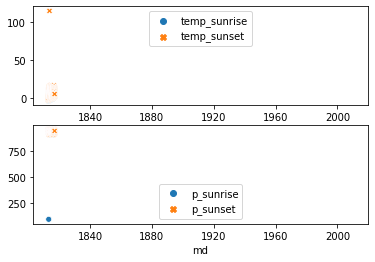

In [5]:
## Plot for visual inspection

# set up plotting with 2 rows, 1 column, select first subplot space
plt.subplot(2, 1, 1)

# select elements to plot together, here temperature at sunrise and sunet
mydata1 = pdex[["md","temp_sunrise","temp_sunset"]].copy()

# set data to wide format indexed on datetime column
mydata1 = mydata1.pivot_table(index = "md")

# use seaborne to plot the data by date
sns.scatterplot(data = mydata1)

# set legend to avoid covering up observations
plt.legend(loc = "upper center")

## plot the entire sunrise and sunset pressure timeseries.

# select second subplot space
plt.subplot(2,1,2)

# copy needed data
mydata2 = pdex[["md","p_sunrise","p_sunset"]].copy()

# set data to wide format indexed on datetime column
mydata2 = mydata2.pivot_table(index = "md")

# use seaborne to plot the data by date
sns.scatterplot(data = mydata2)

# set legend to avoid covering up observations
plt.legend(loc="lower center")

# display graphs

plt.show()

### Search for impossible and unlikely values

We can also search computationally to flag values. The first type of these are physically impossible, here the following:
* temperature <0 K
* pressure <0 hPa

The implausible values are the following:
* Temperature < -80 or > 60
* Pressure < 500 or > 1150

In [6]:
## select values that fall below the above criteria.
impossible_values = pdex[(pdex.p_sunset<= 0)|(pdex.p_sunrise<= 0)|(pdex.temp_sunset<=-270)|(pdex.temp_sunrise<=-270)]
print(F"There are impossible values on the following dates: {impossible_values.md.unique()}")

There are impossible values on the following dates: []


In [7]:
implausible_t = pdex[(pdex.temp_sunset<-80)|(pdex.temp_sunrise<-80)|(pdex.temp_sunset>60)|(pdex.temp_sunrise>60)]
implausible_p = pdex[(pdex.p_sunset<500)|(pdex.p_sunrise<500)|(pdex.p_sunset>1150)|(pdex.p_sunrise>1150)]
print(F"There are implausible temperature values on the following dates: {implausible_t.md.unique()}")
print(F"There are implausible pressure values on the following dates: {implausible_p.md.unique()}")

There are implausible temperature values on the following dates: ['1813-09-16T00:00:00.000000000']
There are implausible pressure values on the following dates: ['1813-03-09T00:00:00.000000000']


### Statistical tests
Identify values that exceed ±4 standard deviations of the timeseries.

In [8]:
# function takes x = df, y = list of columns in df to analyse, returns list of values that exceed 4 standard deviations in their respective series.
def check_std(x,y):
    data = []
    # set test parameter to 4
    c = 4
    try:
        # loop through columns
        for j in y:
            # get standard deviation of values in x
            a = np.std(x[j])
            # get mean of values in x
            b = np.mean(x[j])
            # loop through the elements of each column
            for i in x[j]:
                # test occurs here
                if (i-b)/a > c:
                    # if true append name of column and failed test value to data list
                    datai = [j,i]
                    data.append(datai)
    except:
        print("its a string")
        data.append("not valid")
    return data

#list of columns to pass to check_std function
columns = ["p_sunrise", "p_sunset", "temp_sunrise","temp_sunset"]

more_than_four_stds = check_std(pdex,columns)
print(F"The following time series have a value higher than 4 stds from the mean {more_than_four_stds}")

The following time series have a value higher than 4 stds from the mean [['temp_sunset', 115.2]]


### Sequential analysis
* Often temperature (pressure) observations on consecutive days that differ by more than 25 °C (40 hPa) are flagged,
* four or more equal consecutive values in a row.

In [9]:
## Find the passed number of consecutive values (cutoff) on a passed column (column). 
def find_consecutive_values(column,cutoff):
    # makes a new column that assigns a group indicator to each consecutive value
    pdex["values"] = (pdex[column].diff(1) != 0).cumsum()
    # makes a new dataframe to contain all the different groups and information about each of the consecutive groups
    newpd = pd.DataFrame({"begin_date" : pdex.groupby("values").md.first(), 
              "end_date" : pdex.groupby("values").md.last(),
              "consecutive" : pdex.groupby("values").size(),
              "group":column})
    # returns the groups above a certain cutoff point
    return newpd[newpd["consecutive"]>cutoff].copy()

## get the dataframes for each case, using 4 consecutive values as the cutoff
pressure_sunset = find_consecutive_values("p_sunset",3)
pressure_sunrise = find_consecutive_values("p_sunrise",3)
temperature_sunrise = find_consecutive_values("temp_sunrise",3)
temperature_sunset = find_consecutive_values("temp_sunset",3)

In [10]:
# print dataframes with consecutive values
for i in [temperature_sunset, pressure_sunset, temperature_sunset, pressure_sunrise]:
    if len(i) != 0:
        print(i)

       begin_date   end_date  consecutive        group
values                                                
716    1815-02-24 1815-02-27            4  temp_sunset
       begin_date   end_date  consecutive        group
values                                                
716    1815-02-24 1815-02-27            4  temp_sunset


## Exercise 3 - Homogenization

### Part 1
*For the Craddock test the accumulated normalized differences s are calculated as follows: si=si−1+ai−bi−(am−bm) where a is the reference series, b is the candidate series, am and bm are their long-term means (s0=0). Open the Excel-file or the R file with the txt-data and calculate si. Afterwards, find the breakpoints in the figure on the right in the Excel-sheet*

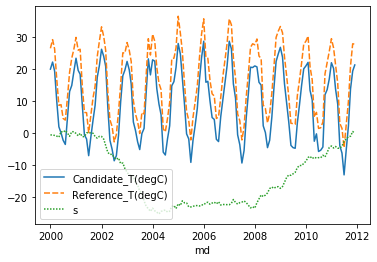

In [11]:
mypd = pd.read_table("homogenization.txt")

#create datetime column to facilitate analysis and charting
mypd["day"] = 1
mypd["year"] = mypd["Yr"]
mypd["month"] = mypd["Mon"]
mypd["md"] = pd.to_datetime(mypd[["year", "month", "day"]])

#obtain long term averages for candidate and reference series
candidate_t = np.mean(mypd["Candidate_T(degC)"])
reference_t = np.mean(mypd["Reference_T(degC)"])

# calculate the difference for each observation
mypd["difference"] = mypd["Reference_T(degC)"] - mypd["Candidate_T(degC)"]-reference_t+candidate_t

# sum up differences up to i = 1...j for each observation j to find s_j for all observations.
mypd["s"] = mypd.difference.cumsum()

# select data for charting
mydata = mypd[["md","Candidate_T(degC)","Reference_T(degC)","s"]]

# reshape dataframe to chart with seaborne defaults
mydata = mydata.pivot_table(index = "md")

# plot the data
sns.lineplot(data=mydata)
plt.show()

As can be seen from visual inspection, the unique sections are:
- 2000-2001 (constant), 
- 2002-2003 (decreasing), 
- 2004-2007 (constant), 
- 2008-2011 (increasing).

This means the break points are Dec 2001, Dec 2003 and Dec 2007.

### Part II
*If possible, detected breaks are corrected. Thereby the most recent part of the series is considered to be correct, and the earlier segments are corrected towards the recent segments, working backwards. The correction amount is the the difference between the mean value of the difference series before and after the break, and this correction amount is subtracted form the segment before the break (see Climandes for further information). Open the Excel-file and try to correct the breaks you have found in the previous exercise (here’s the solution for Excel).*

In [12]:
# use datetime to slice the dataframe according to the time periods before and after the breaks
a = (mypd["md"] < "2001-12-31")
b = (mypd["md"] < "2003-12-31") & (mypd["md"]> "2001-12-31")
c = (mypd["md"] < "2007-12-31") & (mypd["md"] > "2003-12-31")
d = mypd["md"] > "2007-12-31"

# calculate difference in mean between candidate and reference for each period
mean1 = np.mean(mypd.loc[a]["Candidate_T(degC)"])-np.mean(mypd.loc[a]["Reference_T(degC)"])
mean2 = np.mean(mypd.loc[b]["Candidate_T(degC)"])-np.mean(mypd.loc[b]["Reference_T(degC)"])
mean3 = np.mean(mypd.loc[c]["Candidate_T(degC)"])-np.mean(mypd.loc[c]["Reference_T(degC)"])
mean4 = np.mean(mypd.loc[d]["Candidate_T(degC)"])-np.mean(mypd.loc[d]["Reference_T(degC)"])
corrections = [mean4-mean1, mean4-mean2, mean4-mean3,0]

In [13]:
# apply the mean correction to each period
mydata1 = mypd.loc[a].copy()
mydata1["corrected"] = mydata1["Candidate_T(degC)"] + corrections[0]
mydata2 = mypd.loc[b].copy()
mydata2["corrected"] = mydata2["Candidate_T(degC)"] + corrections[1]
mydata3 = mypd.loc[c].copy()
mydata3["corrected"] = mydata3["Candidate_T(degC)"] + corrections[2]
mydata4 = mypd.loc[d].copy()
mydata4["corrected"] = mydata4["Candidate_T(degC)"]

# concatonate the periods together
frames = [mydata1,mydata2,mydata3,mydata4]
newdata = pd.concat(frames)

#add column of new corrected values to original dataset
mypd["corrected"] = newdata["corrected"]

# calculate the difference for each observation
mypd["difference_two"] = mypd["Reference_T(degC)"] - mypd["corrected"]-reference_t+mypd.corrected.mean()

# sum up differences up to i = 1...j for each observation j to find s_j for all observations.
mypd["s_corr"] = mypd.difference_two.cumsum()

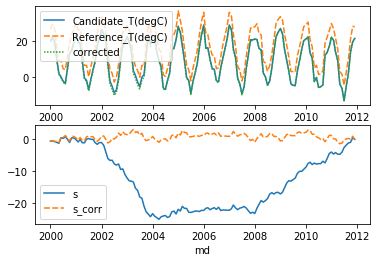

In [14]:
# graph to inspect for errors

plt.subplot(2,1,1)
graphdata = mypd[["md","Candidate_T(degC)","Reference_T(degC)","corrected"]]
graphdata = graphdata.pivot_table(index = "md")
sns.lineplot(data=graphdata)

plt.subplot(2,1,2)
graphdata = mypd[["md","s_corr","s"]]
graphdata = graphdata.pivot_table(index = "md")
sns.lineplot(data=graphdata)

plt.show()

## Exercise 4 - Data Assimilation

### Question 1 Kalman Filter
*Assume that you have a substance that decays radioactively and you want to esimate the amount remaining (or radioactivity)...In addition, you have observations of a Geiger counter (in counts/s). The error of the observation is 2 counts/s, the error of the model is not constant but depends on value; the numbers are are already calculated for you...Now do the assimilation over the first 20 s*

The modelled radiocative decay in the substance for period $\Delta_{t}$ is: $N_{t+1} = N_{t}e^{\lambda\Delta_{t}}$


In [15]:
# read in the data
mypd = pd.read_csv("Reanalysis_DataAssimilation_Exercise1.csv",sep = ";", decimal = ",")

# defines forecast model
def first_func(i,x):
    # apply model formula to passed x, note delta_t = 1
    data = x*math.exp(-0.5)
    # assign value to xb at index i
    mypd.at[i,"xb"] = data
    return

# defines assimilation formula
def second_func(i):
    # select the standard deviation for this observation
    sb = mypd.at[i,"_b2"]
    # next steps applies formula
    constant = sb/(sb+2)
    step1 = mypd.at[i,"y"]-mypd.at[i,"xb"]
    step2= step1*constant
    step3 = mypd.at[i,"xb"] + step2
    #assigns value to x at index i
    data = step3
    mypd.at[i,"x"] = data
    return

i = 0
while i < 21:
    if i == 0:
        # initial case, sets first value
        first_func(1,1000)
        second_func(i)
    else:
        # all other cases, calls first_func on previous index, second_func on current index
        first_func(i,mypd.at[i-1,"x"])
        second_func(i)
    
    #updates the counter variable
    i = i+1
mypd

,t (s),xb,_b2,y,_y2,x
0,0,1000.000000,1000.000,1000,4,1000.000000
1,1,606.530660,920.465,598,4,598.018495
2,2,362.716553,485.640,370,4,369.970128
3,3,224.398226,154.461,228,4,227.953959
4,4,138.261065,38.564,139,4,138.963567
5,5,84.285664,8.299,83,4,83.249668
6,6,50.493476,1.599,51,4,50.718520
7,7,30.762337,0.299,34,4,31.183416
8,8,18.913698,0.054,20,4,18.942257
9,9,11.489060,0.009,13,4,11.495829


### Question 2 Football example

*Let’s return to the football example. The model is that of the inclined throw used above. Have a look at the PDF and download the Excel-sheet or use an R-script to open the data in txt-format. But before starting, try to come up with an algebraic formulation.*

We will need to calcuate several formulas for this exercise.

First is that of the model of the throw. For this we will forecast x and z into the next period:

$x_{t} = x_{t-1}+\mu_{t-1}\Delta_{t,t-1}$

$z_{t} = z_{t-1}+\mu_{t-1}\Delta_{t,t-1}-0.5g\Delta_{t,t-1}^2$

Note that the velocity will change as well for each period, thus the model velocity vector $[u_t,v_t]^{T}$ should be adjusted at each period as well:

$u_{t} = (x_{t}-x_{t-1})/\Delta_{t,t-1}$ and 

$v_t = (z_{t}-z_{t-1})/\Delta_{t,t-1}- 0.5g\Delta_{t,t-1}$

In [16]:
# import the data
mydf = pd.read_csv("Reanalysis_DataAssimilation_Exercise2.csv")

# declare needed constants
g = 9.80665
a = 44.2
b = .01
r = 9
k = 500
const = a*b/(a*a*b+r) 

# define forecast function for x and z

def forecast_func(i):
    # forecast xb(t) zb(t) from x(t-1) z(t-1)
    mydf.at[i,"xb"] = mydf.at[i-1,"x_coord"]+ mydf.at[i-1,"u"]*0.1
    mydf.at[i,"zb"] = mydf.at[i-1,"zed"]+ mydf.at[i-1,"w"]*0.1-0.5*g*.01
    return

# define recalculation of speed function from observed 
def speed_func(i):
    # recalculate velocity from xt, xt-1, z,zt-1
    mydf.at[i,"u"] = (mydf.at[i,"x_coord"]-mydf.at[i-1,"x_coord"])/.1
    mydf.at[i,"w"] = (mydf.at[i,"zed"]-mydf.at[i-1,"zed"])/.1 - 0.5*g*.1
    return

Next we need the correction function. Thanks to the assumptions made, we can treat the variance in our model forecast and our observations as independent, thus we can calculate "observed" x,z from "modelled" x,z in each period with the following formulation:

$x = x_b + constant*(i-ax_b)$, where constant = $(a*b)/(a²*b+r)$, and a,b are defined as constant variance of the error of the model and of the camera respectively

$z = x_b + constant*(i-az_b)$, where constant defined as above.


In [17]:
def correct_func(index):
    # correct the forecast with the camera, accounting for measurement error
    mydf.at[index,"x_coord"] = (mydf.at[index,"i"]-a*mydf.at[index,"xb"])*const+mydf.at[index,"xb"]
    mydf.at[index,"zed"] = mydf.at[index,"zb"]- (mydf.at[index,"j"]-(k-a*mydf.at[index,"zb"]))*const
    return

In [18]:
# solutions have a camera correction made for the initial observation, but don't we know the initial position?
for i in range(len(mydf)):
    if i == 0:
        correct_func(i)
    else:
        forecast_func(i)
        correct_func(i)
        speed_func(i)


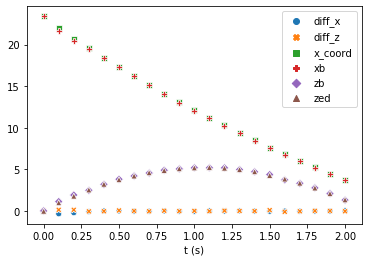

In [19]:
# graph data to visually inspect

#check differences between observed and calculated for each step
mydf["diff_z"]= mydf.zb-mydf.zed
mydf["diff_x"]= mydf.xb-mydf.x_coord
mydata = mydf[["t (s)","xb","x_coord","zed","zb","diff_z","diff_x"]].copy()
mydata = mydata.pivot_table(index = "t (s)")
sns.scatterplot(data = mydata)
plt.show()

## Statistical Downscaling



In [20]:
# import distance package
from scipy.spatial.distance import mahalanobis
import scipy as sp

# load the data
past = pd.read_csv("stats-downscaling-2.csv")
future = pd.read_csv("stats-downscaling-1.csv")

#convert to date-time for ease of processing
past["day"] = past["DAY"]
past["year"] = past["YR"]
past["month"] = past["MON"]
past["md"] = pd.to_datetime(past[["year", "month", "day"]])

future["year"] = future["yr"]
future["month"] = future["mon"]
future["md"] = pd.to_datetime(future[["year", "month", "day"]])

#drop renamed columns
past = past.drop(axis=1,columns={"YR","MON","DAY"})
future = future.drop(axis=1,columns={"yr","mon"})


In [21]:
# get covariance matrix
p = past[['PREC [mm]', 'Z500', 'dZ500/dx', 'dZ500/dy']]
cov_matrix = p.cov().values
cov_matrix = sp.linalg.inv(cov_matrix)
mean = p.mean()

In [22]:
past['all_values'] = past[['Z500', 'dZ500/dx', 'dZ500/dy']].values.tolist()
future['all_values'] = future[['z500', 'dZ500/dx', 'dZ500/dy']].values.tolist()

past.head()

,PREC [mm],Z500,dZ500/dx,dZ500/dy,day,year,month,md,all_values
0,0.0,0.47,0.44,-0.53,1.0,2011.0,4.0,2011-04-01,"[0.47, 0.44, -0.53]"
1,0.0,0.42,0.53,0.64,2.0,2011.0,4.0,2011-04-02,"[0.42, 0.53, 0.64]"
2,0.0,0.42,0.53,1.47,3.0,2011.0,4.0,2011-04-03,"[0.42, 0.53, 1.47]"
3,0.0,-0.31,-0.85,1.56,4.0,2011.0,4.0,2011-04-04,"[-0.31, -0.85, 1.56]"
4,0.0,-0.49,-0.33,0.06,5.0,2011.0,4.0,2011-04-05,"[-0.49, -0.33, 0.06]"


In [31]:


# calculateMahalanobis function to calculate
# the Mahalanobis distance
def calculateMahalanobis(y=None, data=None, cov=None):

	y_mu = y - np.mean(p)
	if not cov:
		cov = np.cov(data.values.T)
	inv_covmat = np.linalg.inv(cov)
	left = np.dot(y_mu, inv_covmat)
	mahal = np.dot(left, y_mu.T)
	return mahal.diagonal()

# data
data = { 'Price': [100000, 800000, 650000, 700000,
				860000, 730000, 400000, 870000,
				780000, 400000],
		'Distance': [16000, 60000, 300000, 10000,
					252000, 350000, 260000, 510000,
					2000, 5000],
		'Emission': [300, 400, 1230, 300, 400, 104,
					632, 221, 142, 267],
		'Performance': [60, 88, 90, 87, 83, 81, 72,
						91, 90, 93],
		'Mileage': [76, 89, 89, 57, 79, 84, 78, 99,
					97, 99]
		}

# Creating dataset
df = pd.DataFrame(data,columns=['Price', 'Distance',
								'Emission','Performance',
								'Mileage'])

# Creating a new column in the dataframe that holds
# the Mahalanobis distance for each row
df['calculateMahalanobis'] = calculateMahalanobis(y=df, data=df[[
'Price', 'Distance', 'Emission','Performance', 'Mileage']])

# Display the dataframe
print(df)


    Price  Distance  Emission  Performance  Mileage  calculateMahalanobis
0  100000     16000       300           60       76              6.055764
1  800000     60000       400           88       89              2.579063
2  650000    300000      1230           90       89              6.762529
3  700000     10000       300           87       57              7.482670
4  860000    252000       400           83       79              2.027900
5  730000    350000       104           81       84              2.380654
6  400000    260000       632           72       78              2.147466
7  870000    510000       221           91       99              4.915337
8  780000      2000       142           90       97              4.025548
9  400000      5000       267           93       99              6.623069


In [28]:
def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()
  
# create new column in dataframe that contains 
# Mahalanobis distance for each row
future['calculateMahalanobis'] = calculateMahalanobis(y=future, data=p, cov=cov_matrix)

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [ ]:
for i in range(len(future)):
    a = mahalanobis(future.at[i,"all_values"],future.at[i,"all_values"],cov_matrix)

In [ ]:


def mahalanobisR(X,meanCol,IC):
    m = []
    for i in range(X.shape[0]):
        m.append(mahalanobis(X.iloc[i,:],meanCol,IC) ** 2)
    return(m)

mR = mahalanobisR(x,mean,Sx)

In [ ]:
future.columns

In [ ]:


var_z500_past = past["Z500"].var()
var_dz500dx_past = past["dZ500/dx"].var()
var_dz500dy_past = past["dZ500/dy"].var()

var_z500_future = future["z500"].var()
var_dz500dx_future = future["dZ500/dx"].var()
var_dz500dy_future = future["dZ500/dy"].var()